<h1>Image Creation</h1>
Using the symmetric digits and assymmetric digits created with <code>symmetricDigits.ipynb</code> and the background texutre generated with <code>randomTexture.ipynb</code> we will create images of certain dimmensions (224x224) combining all elements.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from functions import createSymmetry, createAsymmetry, getSmoothNoiseSin, drawSAandBB, addNoOverflow, getSmoothNoiseWood
import pandas as pd
import rpack
import random

from tqdm import tqdm

<h2>Rectangle Packing</h2>
First problem encountered when facing the problem is the rectangle packing problem. Given a set of rectangles with fixed orientations, find a bounding box of minimum area that contains them all with no overlap. The library <code>rpack</code> has some built in functions to do just that. This will be used to place as many digits in the canvass as possible. Both the symmetric and assymetric digits will be generated randomly. Next a demmonstration of how the algorithm works.

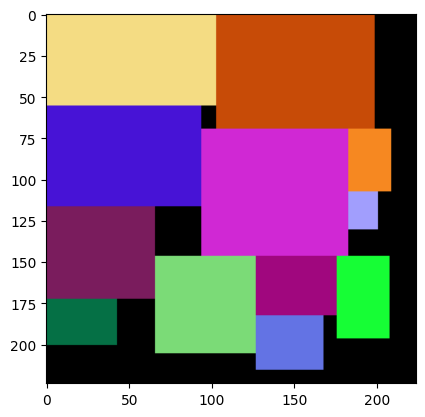

In [53]:
# Inserts into image by replacing the pixels with the desiredposition
def insert(insert, img, position):
    img[position[0]:position[0]+insert.shape[0], position[1]:position[1]+insert.shape[1]] = insert

# Reading the database
mnist = pd.read_csv('MNIST/mnist_test.csv')

# Loop to fill canvass
possible = True
squareSizes = []
while possible:
    square = createAsymmetry(mnist)
    try: 
        p = rpack.pack(squareSizes+[square.shape[:2]],max_width=224,max_height=224)
        squareSizes.append(square.shape[:2])
    except rpack.PackingImpossibleError:
        possible = False

# Drawing the squares
background = np.zeros((224,224,3)).astype(np.uint8)

for idx,square in enumerate(squareSizes):
    rect1 = np.full((square[0], square[1],3),(random.randrange(0,255),random.randrange(0,255),random.randrange(0,255)))
    insert(rect1,background,p[idx])

# Display
plt.imshow(background)
plt.show()


<h3>Using rectangle algorithm to pack the digits</h2>
Now we will use rectangle packing algorithm to pack symmetric and asymmetric digits randomly.

Num decoys: 10


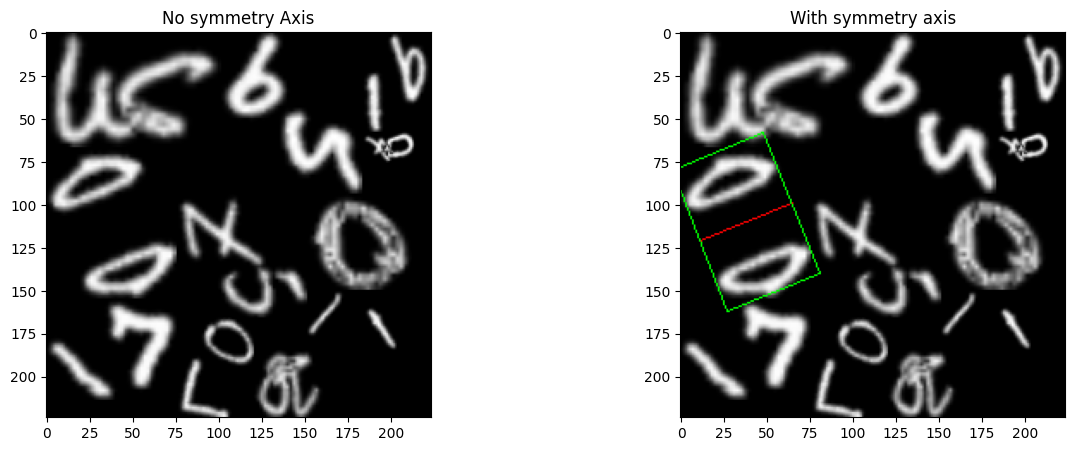

In [55]:
# Displays all bounding boxes and symmetry axises
def drawAllSAandBB(img, symDictionaries):
    for dic in symDictionaries:
        drawSAandBB(img, dic['startAxis'], dic['endAxis'], dic['center'], dic['width'], dic['height'], dic['finalRotation'])
    return img

# Returns image of selected size with randomly placed digits and a symmetries as well as the data for the symmetries
def getRandomDigitsWithSymmetry(id, mnist, size, numSymmetries = None, initialRotation = None, overFlow = None, padding = None, finalRotation = None, resizingPercent = None):
    # Elements for while loop
    possible = True
    squareSizes = []
    elements = []
    # symmetries = []
    symDictionaries = []

    if numSymmetries is None:
        numSymmetries = random.randrange(1,5)

    # Adding symmetries and placing it in the first place of the list
    symmetry,symDictionary = createSymmetry(id,mnist,initialRotation,overFlow,padding,finalRotation,resizingPercent)
    squareSizes.append(symmetry.shape[:2])
    elements.append(symmetry)
    symDictionaries.append(symDictionary)
    for _ in range(numSymmetries - 1):
        symmetry,symDictionary = createSymmetry(random.randrange(len(mnist)),mnist,initialRotation,overFlow,padding,finalRotation,resizingPercent)
        squareSizes.append(symmetry.shape[:2])
        elements.append(symmetry)
        symDictionaries.append(symDictionary)

    positions = []
    # Attemting to add elements until impossible
    while possible:
        square = createAsymmetry(mnist)
        try: 
            positions = rpack.pack(squareSizes+[square.shape[:2]],max_width=size[1],max_height=size[0])
            squareSizes.append(square.shape[:2])
            elements.append(square)
        except rpack.PackingImpossibleError:
            possible = False

    # Final result
    background = np.zeros((size[1],size[0],3)).astype(np.uint8)

    # Inserting the digits on their specific position
    for idx,digit in enumerate(elements):
        insert(digit,background,positions[idx])

    for i in range(numSymmetries):
        symDictionaries[i]['startAxis'] = (symDictionaries[i]['startAxis'][0] + positions[i][1], symDictionaries[i]['startAxis'][1] + positions[i][0])
        symDictionaries[i]['endAxis'] = (symDictionaries[i]['endAxis'][0] + positions[i][1], symDictionaries[i]['endAxis'][1] + positions[i][0])
        symDictionaries[i]['center'] = (symDictionaries[i]['center'][0] + positions[i][1], symDictionaries[i]['center'][1] + positions[i][0])
    
    return background, symDictionaries, len(positions)-len(symDictionaries)

# Creating image from random digit
img, symDictionaries, numDecoys = getRandomDigitsWithSymmetry(random.randint(0,10000), mnist, (224,224))

# Display
display = img.copy()
display = drawAllSAandBB(display, symDictionaries)

print("Num decoys:",numDecoys)
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img), ax[0].set_title(f'No symmetry Axis')
ax[1].imshow(display), ax[1].set_title(f'With symmetry axis')
plt.show()

<h2>Adding Background</h2>
Now we will add the background obtained with <code>randomTexture.ipynb</code>.

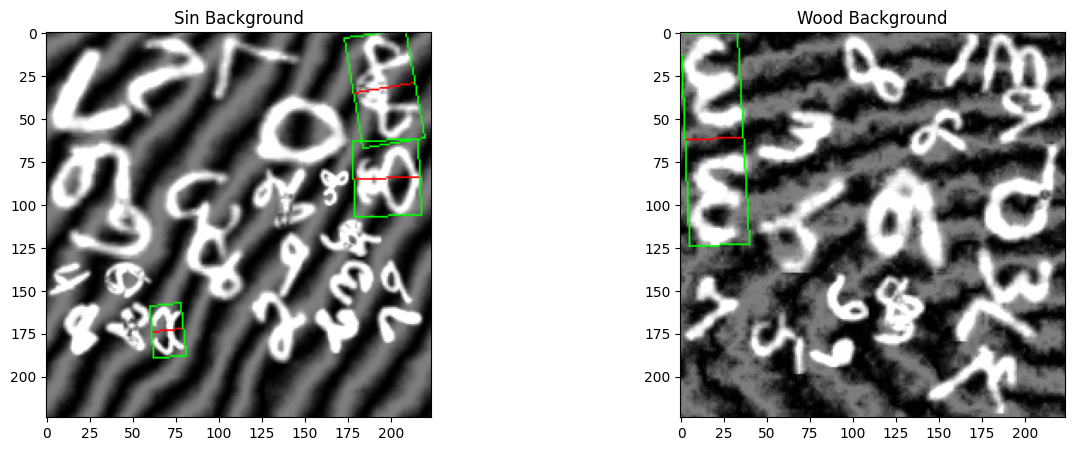

In [58]:
background1, dict = getSmoothNoiseSin((224,224,3), darkness=0.5)
background2, dict = getSmoothNoiseWood((224,224,3), darkness=0.5)
digits1, dic1, _ = getRandomDigitsWithSymmetry(random.randint(0,10000), mnist, (224,224))
digits2, dic2, _ = getRandomDigitsWithSymmetry(random.randint(0,10000), mnist, (224,224))
result1 = addNoOverflow(digits1, background1)
result2 = addNoOverflow(digits2, background2)

# Display
drawAllSAandBB(result1,dic1)
drawAllSAandBB(result2,dic2)
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(result1), ax[0].set_title(f'Sin Background')
ax[1].imshow(result2), ax[1].set_title(f'Wood Background')
plt.show()

<h2>Putting everything together</h2>
Let's now create a function that automatically does all of this.

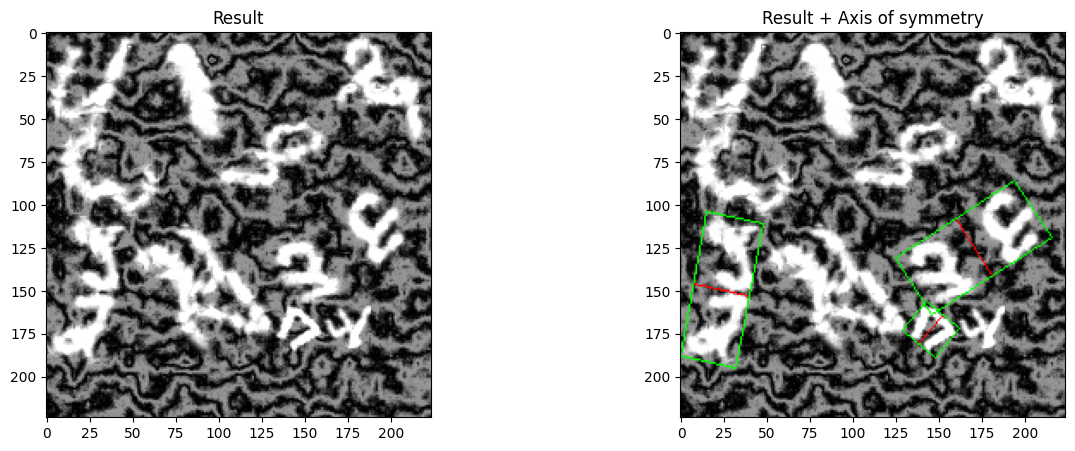

In [59]:
# Returns an image with a local symmetry its dictionary and the backgrounds dictionary
def getLocalSymmetry(shape, mnist, numOfSymmetries = None, idx = None, initialRotation = None, overFlow = None, padding = None, finalRotation = None, 
                     resizingPercent = None, backgroundType = None, darknessBackground = None, xPeriod = None, yPeriod = None, turbPower = None, turbSize = None,
                     offsetX = None, offsetY = None):
    # Digits 
    if idx is None:
        idx = random.randrange(len(mnist))
    # Looping until real combination is found
    found = False
    while not found:
        try:
            digits, dictSymmetries, numDecoys = getRandomDigitsWithSymmetry(idx, mnist, shape, numOfSymmetries, initialRotation, overFlow, padding, finalRotation, resizingPercent)
            found = True
        except:
            found = False

    # Background
    if backgroundType is None:
        backgroundType = random.randrange(2)
    if backgroundType == 0:
        background, dictBack = getSmoothNoiseSin(shape, darknessBackground, xPeriod, yPeriod, turbPower, turbSize)
        dictBack['offsetX'] = 0
        dictBack['offsetY'] = 0
    else:
        background, dictBack = getSmoothNoiseWood(shape, offsetX, offsetY, darknessBackground, xPeriod, yPeriod, turbPower, turbSize)

    # Adding digits and background
    img = addNoOverflow(digits, background)

    # Modifying dictionaries        
    dictBack['backgroundType'] = backgroundType
    dictBack['numDecoys'] = numDecoys
    for dictSym in dictSymmetries:
        dictSym['startAxisX'] = dictSym['startAxis'][0]
        dictSym['startAxisY'] = dictSym['startAxis'][1]
        dictSym['endAxisX'] = dictSym['endAxis'][0]
        dictSym['endAxisY'] = dictSym['endAxis'][1]
        dictSym['centerX'] = dictSym['center'][0]
        dictSym['centerY'] = dictSym['center'][1]

    return img, dictSymmetries, dictBack

img, dictSymmetries, dictBack = getLocalSymmetry((224,224,3),mnist)
# Display
display = img.copy()
drawAllSAandBB(display, dictSymmetries)
_, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].imshow(img), ax[0].set_title(f'Result')
ax[1].imshow(display), ax[1].set_title(f'Result + Axis of symmetry')
plt.show()